In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#import sys
#sys.path.insert(0,"../src/")

from FrankeFunction import FrankeFunction
from linear_regression import *
from bootstrap import *
from cross_validation import *
from stat_tools import *
import unit_tests

%matplotlib inline

In [2]:
# Make sure things are working as expected
unit_tests.OLS_unit_test()
unit_tests.OLS_SVD_unit_test()
unit_tests.Ridge_unit_test()

# Problem 1a)

- Play around with the franke funtion both with & without noise!
- Perform OLS up to 5th order
- Compute R2
- Compute MSE
- Find confidence interval of beta

In [3]:
# Generate test data
n = 300 # Number of data points

x_dat = np.random.uniform(0, 1, n)
y_dat = np.random.uniform(0, 1, n)
z_dat = FrankeFunction(x_dat, y_dat)

# Set up the scaler
scaler = StandardScaler()

In [4]:


# Wrap the analysis in a function to duplicate for Clean & Noisy data
def p1_analysis(x, y, z, degrees):
    
    mse = pd.DataFrame(columns=["train", "test"], index = degrees)
    r2 = pd.DataFrame(columns=["train", "test"], index = degrees)

    #var_b = pd.DataFrame(indices=degrees)
    
    for i, deg in enumerate(degrees):
        X = design_matrix(x, y, deg)
        # Split data, but don't shuffle. OK since data is already randomly sampled! 
        # Fasilitates a direct comparrison of the clean & Noisy data
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2, shuffle=False)
        # Normalize data sets
        X_train = scaler.fit_transform(X_train)
        X_train[:, 0] = np.ones(X_train.shape[0])
        X_test = scaler.fit_transform(X_test)
        X_test[:, 0] = np.ones(X_test.shape[0])

        beta = OLS_SVD(X_train, z_train)
        
        mse["train"][i] = MSE(z_train, X_train @ beta)
        mse["test"][i] = MSE(z_test, X_test @ beta)

        r2["train"][i] = R2(z_train, X_train @ beta)
        r2["test"][i] = R2(z_test, X_test @ beta)

        #var_b.append([deg, var_beta(z_train, X_train)])
        
    return mse, r2, 0#, var_b

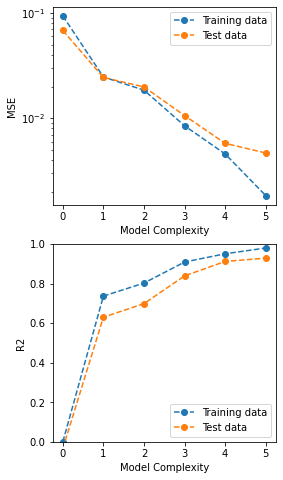

In [5]:
degrees = np.arange(0, 6) # Degrees of the polynomial

# Generate data
MSE_clean, R2_clean, var_b_clean = p1_analysis(x_dat, y_dat, z_dat, degrees)

plt.figure(figsize=(4,8))
plt.tight_layout()
# Plot MSE
plt.subplot(211)
plt.semilogy(degrees, MSE_clean["train"],"o--", label = "Training data")
plt.semilogy(degrees, MSE_clean["test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.legend()
# Plot R2
plt.subplot(212)
plt.plot(degrees, R2_clean["train"],"o--", label = "Training data")
plt.plot(degrees, R2_clean["test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("R2")
plt.ylim([0,1])
plt.legend()

How does the model respond to noise?

[]

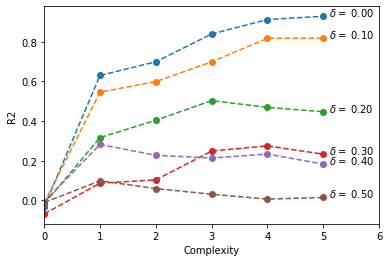

In [6]:
noises = np.linspace(0, .5, 6)
degrees = np.arange(0, 6)

for noise in noises:
    # Generate a new noisy dataset
    z_dat_noisy = z_dat + np.random.normal(0, 1, n) * noise
    MSE_noisy, R2_noisy, var_b_noisy = p1_analysis(x_dat, y_dat, z_dat_noisy,degrees)
    
    plt.plot(degrees, R2_noisy["test"], "o--")
    plt.annotate("$\delta=$ %.2f" % noise, [degrees[-1] + .1,R2_noisy["test"].iloc[-1]])

plt.xlim([0, degrees[-1] + 1])
plt.xlabel("Complexity")
plt.ylabel("R2")
plt.plot()

# Problem 1b)
- Replicate Fig 2.11 from Hastie et al using bootstrap
- Bias variance analysis

In [7]:
def p2_analysis(x, y, z, degrees, N_bootstraps):
    
    columns = [
        "MSE train",
        "MSE test",
        "R2 train",
        "R2 test",
        "Bias train",
        "Bias test",
        "Variance train",
        "Variance test",
    ]
    
    df = pd.DataFrame(columns=columns)
    
    for i, deg in enumerate(degrees):
        X = design_matrix(x, y, deg)
        # Split data, but don't shuffle. OK since data is already randomly sampled! 
        # Fasilitates a direct comparrison of the clean & Noisy data
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2, shuffle=False)
        
        # Normalize data sets
        X_train = scaler.fit_transform(X_train)
        X_train[:, 0] = np.ones(X_train.shape[0])
        X_test = scaler.fit_transform(X_test)
        X_test[:, 0] = np.ones(X_test.shape[0])
        
        output = bootstrap(
            X_train, 
            X_test, 
            z_train, 
            z_test,
            bootstraps = N_bootstraps,
            regression = linear_regression.OLS_SVD
        )

        df = df.append(pd.DataFrame(output, index=[deg]))
    
    return df

In [8]:
degrees = np.arange(1, 20)
N_bootstraps = 100
data_bootstrap = p2_analysis(x_dat, y_dat, z_dat, degrees, N_bootstraps)

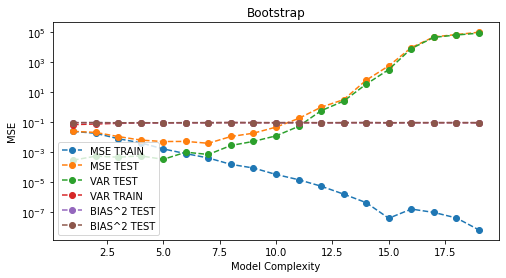

In [9]:
plt.figure(figsize=(8,4))
degrees = np.arange(1, 20) 
plt.semilogy(degrees, data_bootstrap["MSE train"],"o--", label = "MSE TRAIN")
plt.semilogy(degrees, data_bootstrap["MSE test"],"o--", label = "MSE TEST")
plt.semilogy(degrees, data_bootstrap["Variance test"],"o--", label = "VAR TEST")
plt.semilogy(degrees, data_bootstrap["Variance train"],"o--", label = "VAR TRAIN")
plt.semilogy(degrees, data_bootstrap["Bias test"],"o--", label = "BIAS^2 TEST")
plt.semilogy(degrees, data_bootstrap["Bias train"],"o--", label = "BIAS^2 TEST")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.title("Bootstrap")
plt.legend(loc="lower left")

In [10]:
data_bootstrap

,MSE train,MSE test,R2 train,R2 test,Bias train,Bias test,Variance train,Variance test
1,2.448339e-02,0.024669,0.733933,3.768412e-01,0.093245,0.093245,0.068771,0.000295
2,1.826932e-02,0.020812,0.803830,4.742728e-01,0.094328,0.094328,0.076083,0.000544
3,8.001255e-03,0.011105,0.911856,7.194892e-01,0.091839,0.091839,0.083856,0.000464
4,4.190140e-03,0.006406,0.953789,8.381695e-01,0.092386,0.092386,0.088214,0.000566
5,1.655586e-03,0.005150,0.981725,8.699042e-01,0.091786,0.091786,0.090112,0.000334
6,8.027749e-04,0.005236,0.991244,8.677335e-01,0.093076,0.093076,0.092264,0.001005
7,4.120632e-04,0.003941,0.995497,9.004502e-01,0.092906,0.092906,0.092505,0.000707
8,1.547373e-04,0.011157,0.998336,7.181629e-01,0.094426,0.094426,0.094269,0.002813
9,8.847076e-05,0.018533,0.999032,5.318464e-01,0.093341,0.093341,0.093259,0.005252
10,3.285466e-05,0.047128,0.999638,-1.904779e-01,0.092689,0.092689,0.092660,0.012302


# Problem 1c)
- Do cross validation on the dataset. Compare MSE with bootstrap

In [11]:
def p3_analysis(x, y, z, degrees, k):
    
    columns = [
        "MSE train", "MSE test",
        "R2 train", "R2 test"
    ]
    
    df = pd.DataFrame(columns=columns)
    
    for i, deg in enumerate(degrees):
        X = design_matrix(x, y, deg)
    
        # Normalize the design matrix
        X = scaler.fit_transform(X)
        X[:, 0] = np.ones(X.shape[0])
        
        output = cross_validation(X, z, k_folds = k, regression=linear_regression.OLS_SVD)
        
        df = df.append(pd.DataFrame(output, index=[deg]))
        
        
    return df

In [12]:
degrees = np.arange(1, 16)
dat_cross = p3_analysis(x_dat, y_dat, z_dat, degrees, k=55)

dat_cross

,MSE train,MSE test,R2 train,R2 test
1,0.024250,0.024124,0.726152,0.471382
2,0.018339,0.018930,0.792902,0.519952
3,0.008375,0.008844,0.905418,0.652565
4,0.004335,0.005022,0.951042,0.862025
5,0.001868,0.002109,0.978905,0.941346
6,0.000994,0.001276,0.988777,0.965677
7,0.000502,0.000736,0.994335,0.984546
8,0.000220,0.000473,0.997519,0.986855
9,0.000151,0.000632,0.998292,0.971401
10,0.000059,0.000752,0.999336,0.958450


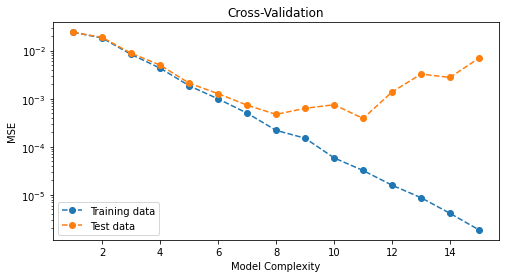

In [13]:
plt.figure(figsize=(8,4))

plt.semilogy(degrees, dat_cross["MSE train"],"o--", label = "Training data")
plt.semilogy(degrees, dat_cross["MSE test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.title("Cross-Validation")
plt.legend(loc="lower left")

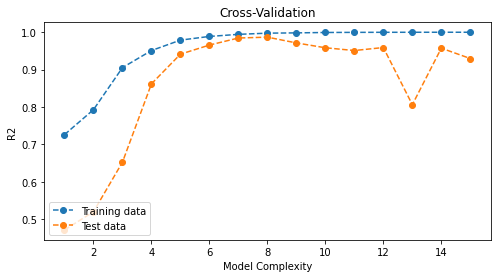

In [14]:
plt.figure(figsize=(8,4))

plt.plot(degrees, dat_cross["R2 train"],"o--", label = "Training data")
plt.plot(degrees, dat_cross["R2 test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("R2")
plt.title("Cross-Validation")
plt.legend(loc="lower left")

# Problem 1d)
- Do same analysis, but with Ridge regression

# Problem 1e)
- Do Same analysis, but with Lasso Regression

# Problem 1f)
- Download real data!

# Problem 1d)
= Analyse real data using wisdom gained from Franke Function!

In [15]:
def k_fold_split(X, z, k_folds = 5):
    perm = np.random.permutation(len(z))
    perm = np.split(perm, k_folds)
    return perm

X =  np.ones([5, 5])
z = np.ones([5])
for i in range(5):
    X[i] *= i
    z[i] *= i